# Cell type comparison analysis

In [1]:
import scrabbit
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import json

## Plotting utils

In [ ]:
# Save dictionary
# with open(data_path + "celltype_colours.json", 'w') as fp:
#   json.dump(celltype_colours, fp,sort_keys=True,indent=4)

# Load dictionary
# with open(data_path + "celltype_colours.json", 'r') as fp:
#    celltype_colours = json.load(fp)

In [2]:
sc.set_figure_params(dpi=150,dpi_save=600)
sc.settings.figdir = "../plots/celltype_comparison/"


## Load data

In [3]:
r_data = sc.read_h5ad("../data-in/rabbit/anndata.h5ad")
r_data

AnnData object with n_obs × n_vars = 146133 × 30725
    obs: 'cell', 'barcode', 'sample', 'stage', 'batch', 'doub.density', 'doublet', 'stripped', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'sizeFactor', 'celltype', 'singler', 'leiden_res1', 'leiden_res2', 'leiden_res1_5', 'leiden_res2_5', 'leiden_res3', 'leiden_res5', 'leiden_res10', 'leiden_res6', 'leiden_res7', 'leiden_res8', 'anatomical_loc', 'day', 'celltype_old'
    var: 'ensembl_ids'
    uns: 'anatomical_loc_colors', 'celltype_colors', 'celltype_old_colors', 'draw_graph', 'leiden', 'neighbors', 'singler_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [5]:
r_genes = pd.read_csv("../data-in/rabbit/genes.tsv",sep="\t")
r_data.var = r_genes

In [11]:
r_celltype = pd.read_csv("../data-in/celltype_annotation/annotations_12-10-21.tsv",sep="\t",index_col=0)
r_data.obs["celltype"] = r_celltype["assigned_celltype"].astype("category")

In [4]:
m_data = sc.read_h5ad("../data-in/mouse/anndata.h5ad")
m_data

AnnData object with n_obs × n_vars = 430339 × 23972
    obs: 'sample', 'stage', 'stage.mapped', 'celltype', 'celltype.extended', 'tube_name', 'somite_count', 'cluster', 'cluster.sub', 'louvain', 'leiden', 'celltype.clustering', 'day'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'draw_graph', 'leiden', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
m_genes = pd.read_csv("../data-in/mouse/genes.tsv",sep="\t")
m_data.var.index = m_genes["gene_name"]

In [10]:
orthologs = pd.read_csv("../data-in/orthologs/mmusculus.tsv",sep="\t",names=["rabbit","mouse"],header=0)
orthologs

,rabbit,mouse
ENSOCUG00000000006,ENSOCUG00000000006,ENSMUSG00000026102
ENSOCUG00000000007,ENSOCUG00000000007,ENSMUSG00000028480
ENSOCUG00000000008,ENSOCUG00000000008,ENSMUSG00000070999
ENSOCUG00000000009,ENSOCUG00000000009,ENSMUSG00000028478
ENSOCUG00000000010,ENSOCUG00000000010,ENSMUSG00000028479
...,...,...
ENSOCUG00000039241,ENSOCUG00000039241,ENSMUSG00000022255
ENSOCUG00000039281,ENSOCUG00000039281,ENSMUSG00000024885
ENSOCUG00000039392,ENSOCUG00000039392,ENSMUSG00000014852
ENSOCUG00000039553,ENSOCUG00000039553,ENSMUSG00000009566


## Compute gene specificity

In [14]:
ctype_shared = set(r_data.obs["celltype"]).intersection(set(m_data.obs["celltype"]))
ctype_shared

{'Allantois',
 'Allantois endothelium',
 'Anterior Primitive Streak',
 'Anterior cardiopharyngeal progenitors',
 'Anterior somitic tissues',
 'Cardiomyocytes FHF 1',
 'Cardiomyocytes FHF 2',
 'Cardiopharyngeal progenitors',
 'Caudal mesoderm',
 'Cranial mesoderm',
 'Dermomyotome',
 'EMP',
 'Embryo proper endothelium',
 'Endocardium',
 'Epiblast',
 'Epicardium',
 'Erythroid',
 'Gut tube',
 'Haematoendothelial progenitors',
 'Lateral plate mesoderm',
 'Limb mesoderm',
 'MEP',
 'Megakariocytes',
 'Mesenchyme',
 'Mesothelium',
 'Mesothelium-endothelium/Masked',
 'Migratory neural crest',
 'NMPs',
 'NMPs/Mesoderm-biased',
 'Nascent mesoderm',
 'Nephron progenitors',
 'Non-neural ectoderm 2',
 'Non-neural ectoderm 4',
 'Notochord',
 'PGC',
 'Pharyngeal endoderm',
 'Placodal ectoderm',
 'Posterior somitic tissues',
 'Presomitic mesoderm',
 'Primitive Streak',
 'Sclerotome',
 'Somitic mesoderm',
 'Thyroid primordium',
 'Venous endothelium',
 'Visceral endoderm',
 'YS endothelium'}

In [11]:
# nan entries correspond to non-expressed genes, can be removed prior
def calcGeneSpecificity(adata,group_by):
    mask = pd.get_dummies(adata.obs[group_by])
    ncells=mask.sum(0)
    ncells_mat = scipy.sparse.diags(1/ncells)
    mask = scipy.sparse.csr_matrix(mask).T

    ctype_sum = mask@adata.X
    ctype_mean = ncells_mat@ctype_sum
    
    N = ctype_mean.shape[0]
    row_sums = np.squeeze(np.asarray(ctype_mean.sum(axis=1)))[:,None]
    gspec = ctype_mean/(row_sums/N) #TODO: make this sparse    
    
    return(gspec)

In [19]:
# Filter non-expressing one-to-one ortholog genes and cells of common cell type
def filterGenes(adata,orthologs,ctype_shared,hvgs=None):
    nz_genes = sc.pp.filter_genes(adata,min_counts=1,inplace=False)
    filt = adata[adata.obs["celltype"].isin(ctype_shared),nz_genes[0]]
    filt = filt[:,filt.var.index.isin(orthologs)]
    
    if hvgs is not None:
        #sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata,n_top_genes=hvgs)
        
    return(filt)

# Extract one-to-one orthologs in both filtered datasets
def getCommonOrthologs(r_filt,m_filt,orthologs,use_hvgs=False,join_type="intersect"):
    r_genes = r_filt.var.index
    m_genes = m_filt.var.index
    
    if(use_hvgs):
        r_genes = r_genes[r_filt.var["highly_variable"]]
        m_genes = m_genes[m_filt.var["highly_variable"]]
        
    if(join_type=="union"): 
        genes_in_both = orthologs.loc[orthologs["rabbit"].isin(r_genes) | orthologs["mouse"].isin(m_genes),:]
    else:
        # TODO: Make sure features are in common after this
        genes_in_both = orthologs.loc[orthologs["rabbit"].isin(r_genes) & orthologs["mouse"].isin(m_genes),:]
    
    return(genes_in_both)
    

In [13]:
def getConsistent()

def runGeneSpecificity(rabbit,mouse,orthologs,ctype_shared,hvgs=None):
    r_filt = filterGenes(rabbit,orthologs["rabbit"],ctype_shared,hvgs=hvgs)
    m_filt = filterGenes(mouse,orthologs["mouse"],ctype_shared,hvgs=hvgs)
    
    use_hvgs=False
    if hvgs is not None:
        use_hvgs = True
        
    genes_in_both = getCommonOrthologs(r_filt,m_filt,orthologs,use_hvgs=use_hvgs,join_type="intersect")
    r_filt = r_filt[:,genes_in_both["rabbit"]]
    m_filt = m_filt[:,genes_in_both["mouse"]]
    
    r_gspec = calcGeneSpecificity(r_filt,"celltype")
    r_gspec = np.array(r_gspec)
    
    m_gspec = calcGeneSpecificity(m_filt,"celltype")
    m_gspec = np.array(m_gspec)
    
    N = len(ctype_shared)
    gspec_cor = np.corrcoef(r_gspec,m_gspec)
    gspec_cor = gspec_cor[0:N,N:]
    
    ctype_list = np.sort(list(ctype_shared)) # ctype_shared a set so careful of ordering
    gspec_cor = pd.DataFrame(gspec_cor,columns=ctype_list,index=ctype_list)

    return(gspec_cor)
    

In [178]:
gspec_cor = runGeneSpecificity(r_data,m_data,orthologs,ctype_shared,hvgs=3000)

/hps/software/users/marioni/dkeitley/miniconda3/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/hps/software/users/marioni/dkeitley/miniconda3/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/hps/software/users/marioni/dkeitley/miniconda3/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [73]:
r_filt

View of AnnData object with n_obs × n_vars = 92112 × 671
    obs: 'cell', 'barcode', 'sample', 'stage', 'batch', 'doub.density', 'doublet', 'stripped', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'sizeFactor', 'celltype', 'singler', 'leiden_res1', 'leiden_res2', 'leiden_res1_5', 'leiden_res2_5', 'leiden_res3', 'leiden_res5', 'leiden_res10', 'leiden_res6', 'leiden_res7', 'leiden_res8', 'anatomical_loc', 'day', 'celltype_old'
    var: 'ensembl_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'anatomical_loc_colors', 'celltype_colors', 'celltype_old_colors', 'draw_graph', 'leiden', 'neighbors', 'singler_colors', 'umap', 'log1p', 'hvg'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [74]:
r_gspec

array([[9.71270648e-03, 4.59272646e-02, 1.02218826e-04, ...,
        1.56843749e-02, 1.55715294e-03, 6.85259283e-04],
       [1.53628166e-02, 4.67202430e-02, 0.00000000e+00, ...,
        1.35875764e-02, 8.34256371e-02, 1.37380969e-03],
       [3.40284254e-02, 1.78872207e-01, 2.22146334e-02, ...,
        1.58642106e-01, 8.68855302e-03, 6.70238542e-03],
       ...,
       [5.97769335e-03, 2.35558754e-02, 1.89098525e-04, ...,
        8.36757425e-03, 4.77365003e-02, 1.22914022e-03],
       [4.20267920e-03, 1.84812726e-01, 0.00000000e+00, ...,
        1.03893608e-01, 4.28172522e-04, 4.36385197e-02],
       [1.61236196e-03, 3.55363329e-02, 1.29329980e-04, ...,
        5.17319898e-03, 1.73862274e-02, 7.75979824e-04]])

## Plot results

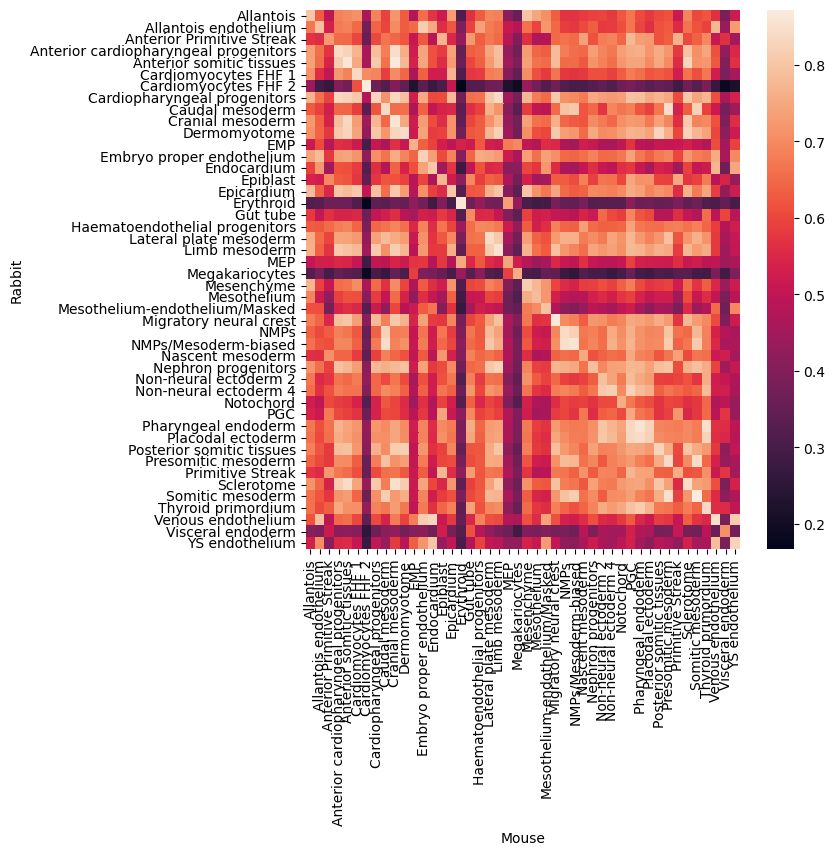

In [180]:
fig, ax = plt.subplots(
        figsize=(7,7))

sns.heatmap(gspec_cor,xticklabels=True, yticklabels=True,ax=ax)
plt.xlabel('Mouse', fontsize = 10) 
plt.ylabel('Rabbit', fontsize = 10) 

plt.show()

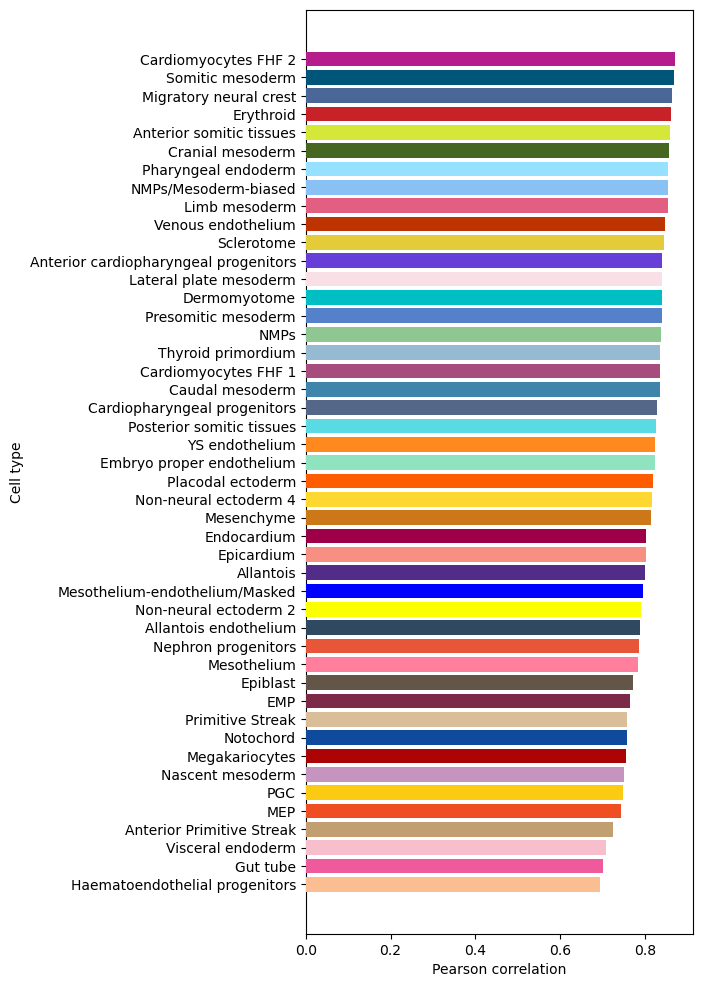

In [179]:
plt.rcdefaults()

fig, ax = plt.subplots(
        figsize=(5,12))

data = np.diagonal(gspec_cor)
cor_order=np.argsort(data)
#ax.set_facecolor('white')
#ax.grid(b=True,zorder=0)
celltype_colours = scrabbit.plot_utils.getCelltypePalette()
ax.barh(y=gspec_cor.index[cor_order], 
        width=data[cor_order],
        color=[celltype_colours[x] for x in gspec_cor.columns[cor_order].values],
       zorder=3)

# Add text
#for i, v in enumerate(data[cor_order]):
#    ax.text(v-0.25 , i-0.3 , "{:0.4f}".format(v), color='black')
    
    
ax.set_xlabel('Pearson correlation')
ax.set_ylabel('Cell type')  

plt.savefig("gspec_ranked_bar_2000hvgs_nogrid.pdf", dpi=300,bbox_inches="tight")

In [189]:
exe_celltypes = ["Visceral endoderm","Mesothelium","Allantois endothelium", "Mesothelium-endothelium/Masked",
                 "YS endothelium","Non-neural ectoderm 2"]

In [190]:
data = np.diagonal(gspec_cor)
cor_order=np.argsort(-data)
#ax.set_facecolor('white')
#ax.grid(b=True,zorder=0)
celltype_colours = scrabbit.plot_utils.getCelltypePalette()

df = pd.DataFrame({"x":gspec_cor.index[cor_order],
                 "y":data[cor_order],
                "colour":[celltype_colours[x] for x in gspec_cor.columns[cor_order].values],
                  "isExE": [x in exe_celltypes for x in gspec_cor.columns[cor_order].values]}
                 )


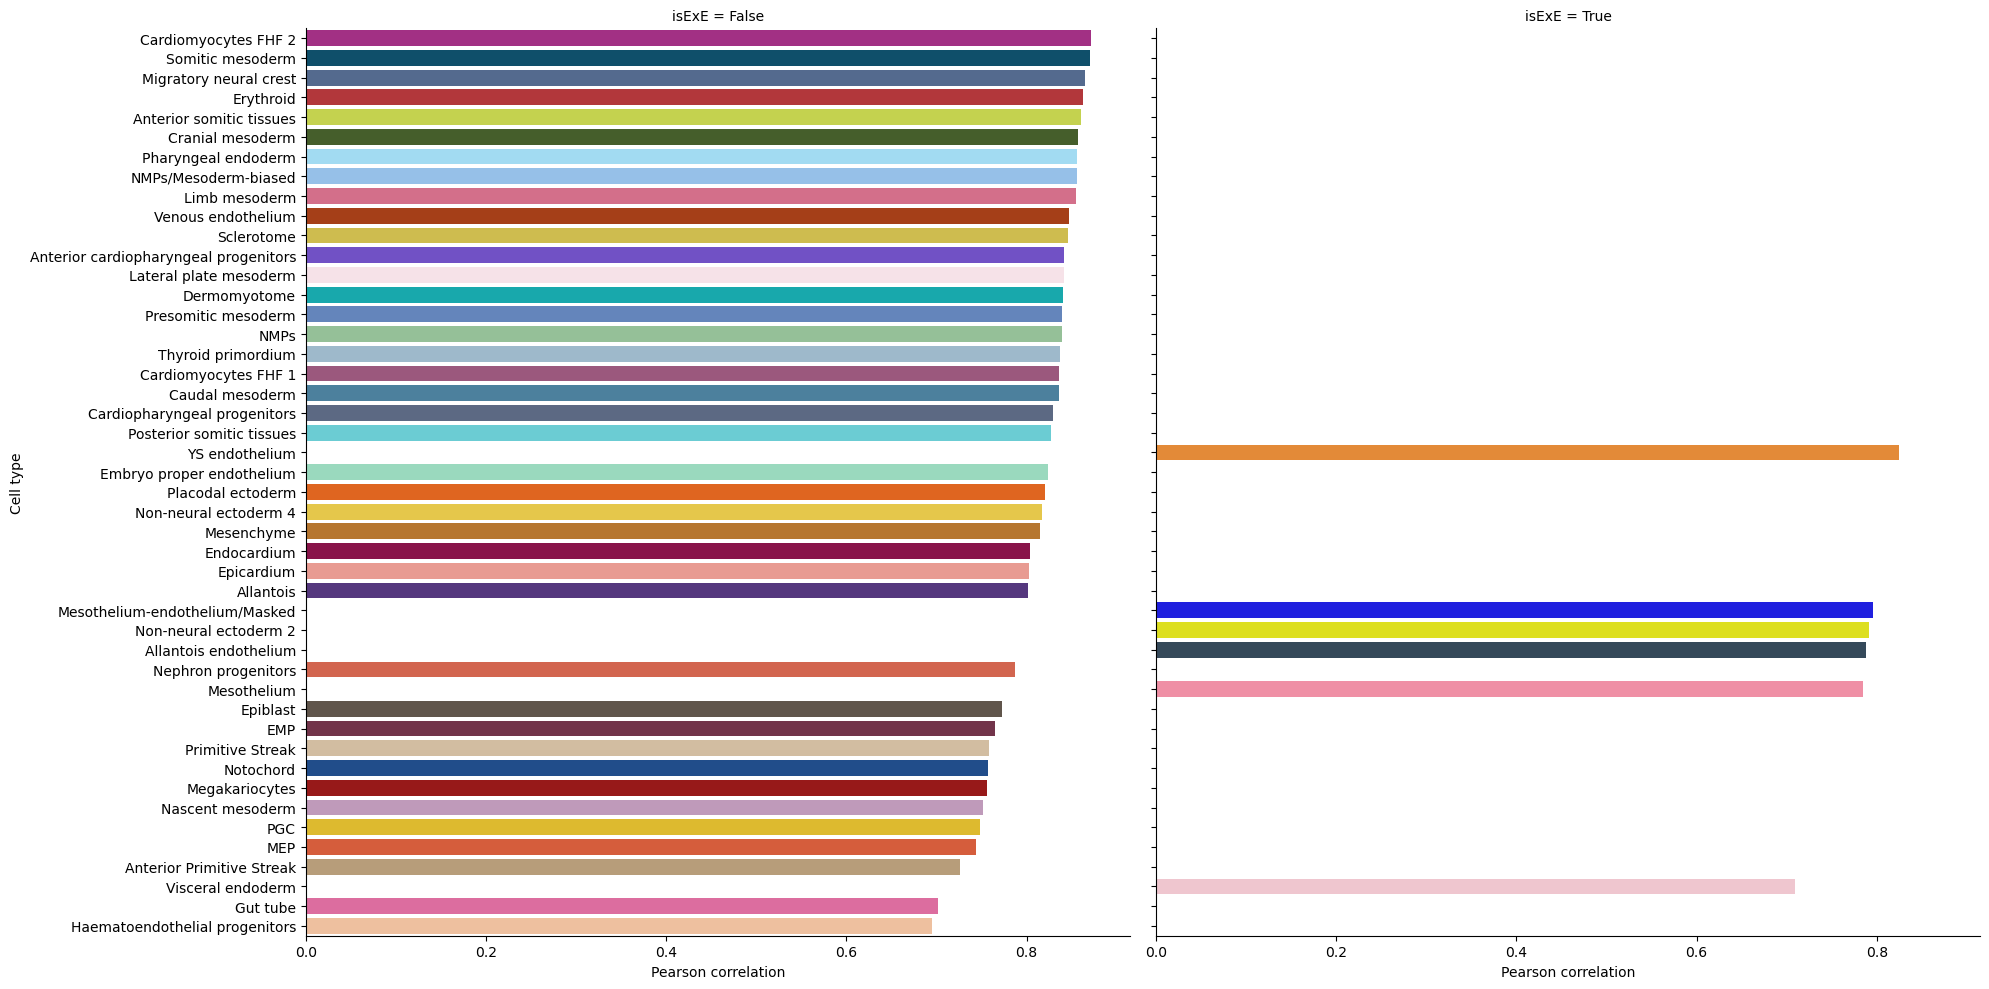

In [191]:
g = sns.catplot(x="y", y="x", col="isExE", color="colour",palette=scrabbit.plot_utils.getCelltypePalette(),
                data=df, kind="bar",height=10)
g.set(xlabel='Pearson correlation', ylabel='Cell type')

## Find genes with large differences in gene specificity

In [4]:
r_val = (r_gspec.transpose()-np.mean(r_gspec,axis=1)).transpose()
m_val = (m_gspec.transpose()-np.mean(m_gspec,axis=1)).transpose()
vals = np.absolute(r_val-m_val)

NameError: name 'r_gspec' is not defined

In [198]:
top = np.argpartition(vals, -5, axis=1)[:,(-5):]
#bottom = np.argpartition(vals, 5, axis=1)[:, :5]

In [199]:
m_filt.var
m_filt.var.iloc[top[list(ctype_list).index("Epiblast"),:]]

,highly_variable,means,dispersions,dispersions_norm
id,,,,
ENSMUSG00000032387,True,0.524045,0.251634,2.379563
ENSMUSG00000005892,True,0.171125,0.967777,4.997798
ENSMUSG00000029337,True,0.099118,0.647763,3.099458
ENSMUSG00000000805,True,0.739659,0.646925,4.973704
ENSMUSG00000019874,True,0.144711,0.504173,2.325225


In [3]:
top[list(ctype_list).index("Epiblast"),:]

NameError: name 'top' is not defined

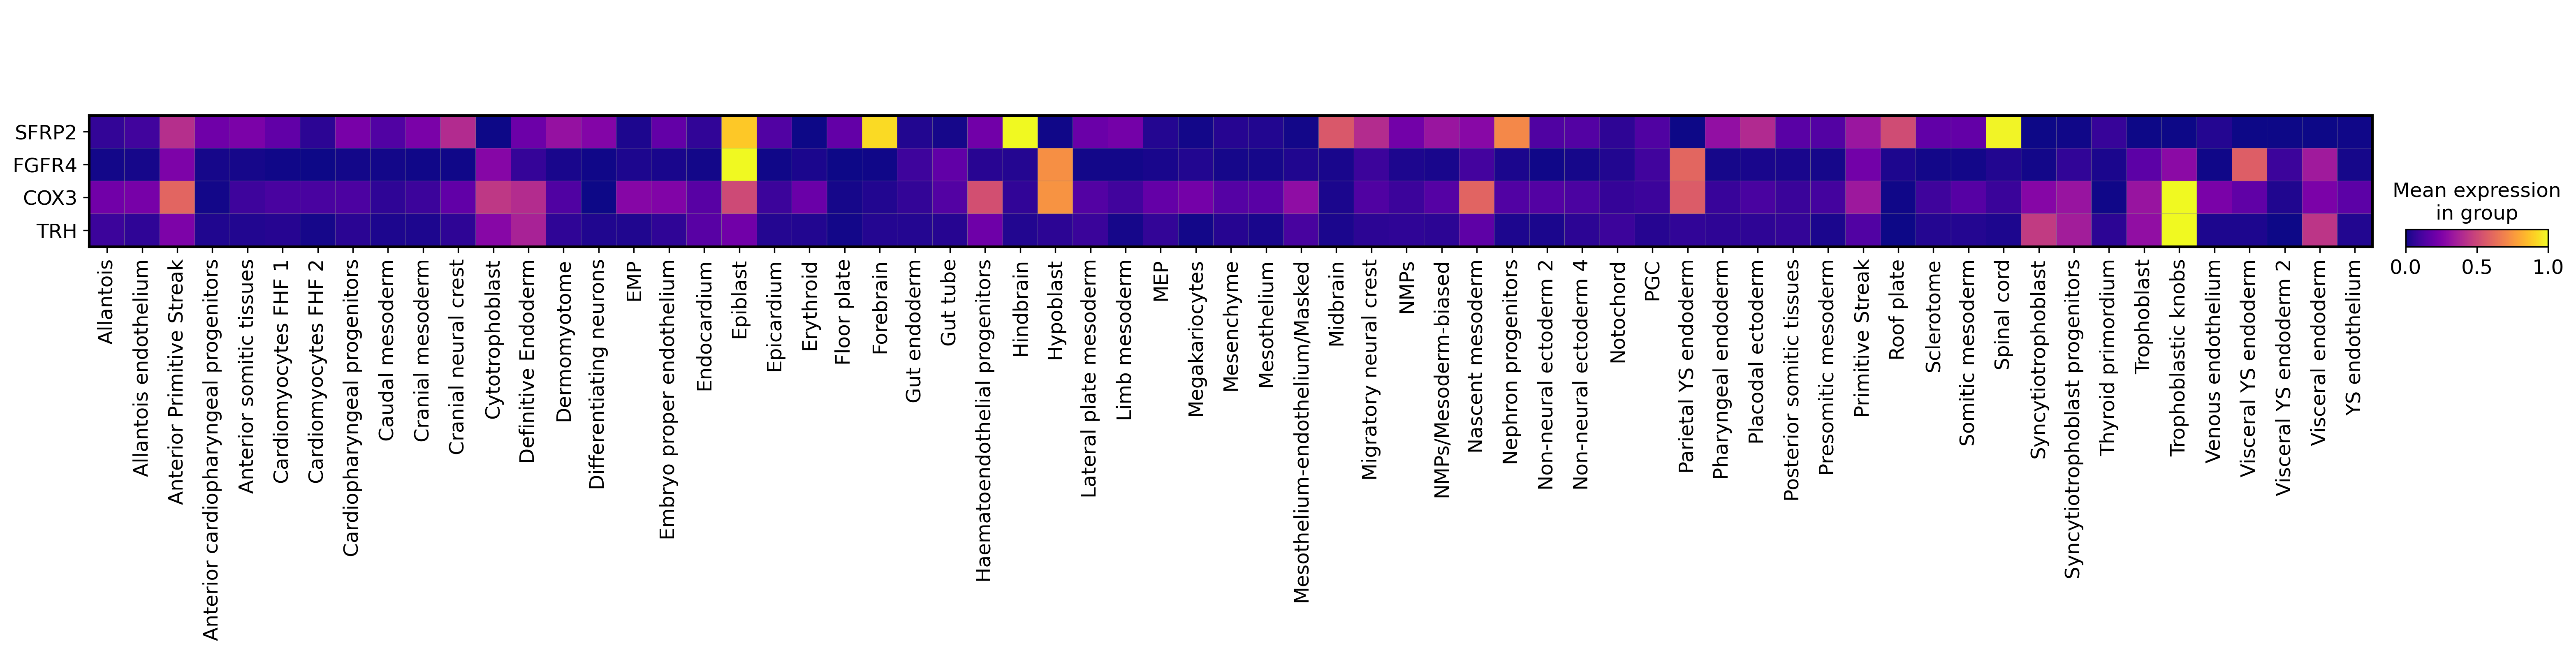

In [14]:
sc.pl.matrixplot(r_data,["SFRP2","FGFR4","COX3","TRH"],groupby="celltype",swap_axes=True,cmap="plasma",
                standard_scale="var")

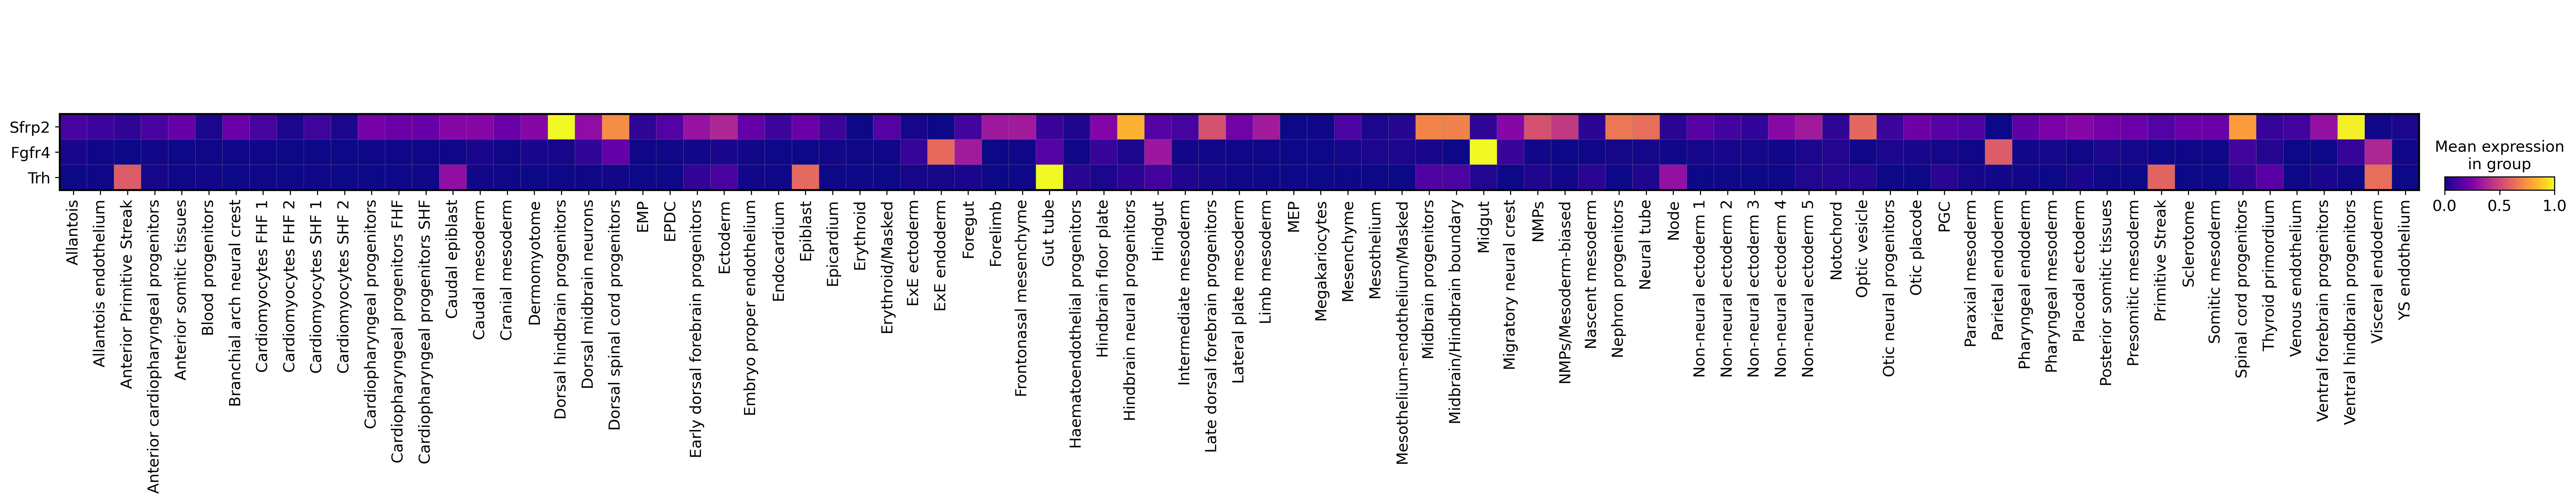

In [18]:
sc.pl.matrixplot(m_data,["Sfrp2","Fgfr4","Trh"],groupby="celltype",swap_axes=True,cmap="plasma",
                standard_scale="var")

### Tests

In [315]:

# Assuming same #genes and #celltypes in both species
n_ctypes = 20
n_cells = 300 # >> n_ctypes
n_genes = 500 # >> n_ctypes

g_per_ctype = int(n_genes/n_ctypes)
c_per_ctype = int(n_cells/n_ctypes)


g_groups = [random.sample(range(n_genes),k=g_per_ctype) for p in range(n_ctypes)]

r_cells = list(range(n_cells))
random.shuffle(r_cells)
r_ctype_groups = [r_cells[i::n_ctypes] for i in range(n_ctypes)]

m_cells = list(range(n_cells))
random.shuffle(m_cells)
m_ctype_groups = [m_cells[i::n_ctypes] for i in range(n_ctypes)]

r_sim =  np.zeros((n_cells,n_genes))
m_sim =  np.zeros((n_cells,n_genes))

for ct in range(n_ctypes):
    g_group = g_groups[ct]
    c_group = r_ctype_groups[ct]
    for c in c_group:
        r_sim[c,g_group] = np.random.negative_binomial(1,0.3, size=g_per_ctype)
        
for ct in range(n_ctypes):
    g_group = g_groups[ct]
    c_group = m_ctype_groups[ct]
    for c in c_group:
        m_sim[c,g_group] = np.random.negative_binomial(1,0.3, size=g_per_ctype)


        
# Compute average expression per cell type
r_avgs = np.zeros((n_ctypes,n_genes))
for ct in range(n_ctypes):
    c_group = r_ctype_groups[ct]
    r_avgs[ct,:] = np.mean(r_sim[c_group,:],axis=0)
    
m_avgs = np.zeros((n_ctypes,n_genes))
for ct in range(n_ctypes):
    c_group = m_ctype_groups[ct]
    m_avgs[ct,:] = np.mean(m_sim[c_group,:],axis=0)
    

# Compute gspec
r_gspec = r_avgs/((np.sum(r_avgs,axis=1)/n_ctypes)[:,None])
m_gspec = m_avgs/((np.sum(m_avgs,axis=1)/n_ctypes)[:,None])

# Compute correlation
out = np.zeros((n_ctypes,n_ctypes))
for cta in range(n_ctypes):
    for ctb in range(n_ctypes):
        out[cta,ctb] = scipy.stats.pearsonr(r_gspec[cta,:],m_gspec[ctb,:])[0]
        


<AxesSubplot:>

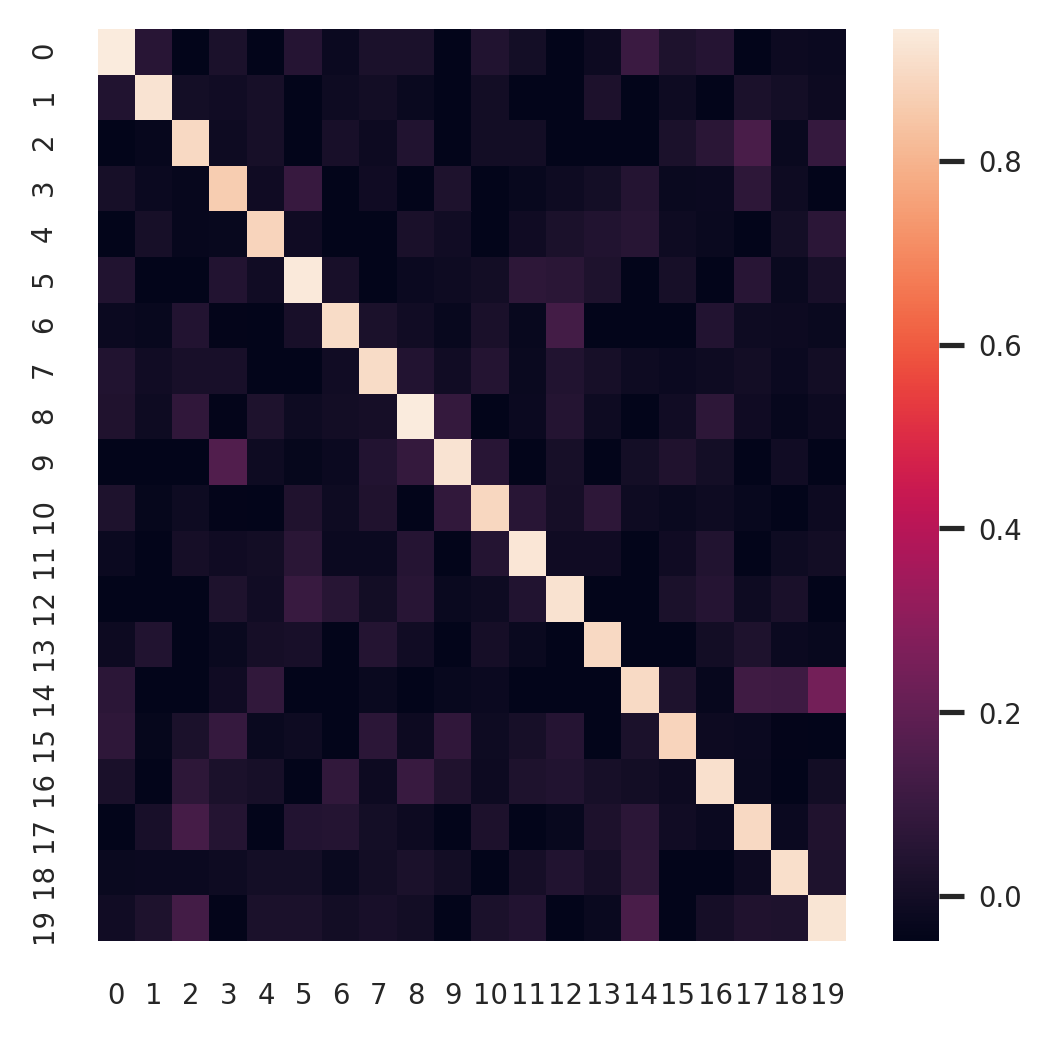

In [316]:
sns.heatmap(out,xticklabels=True, yticklabels=True)


In [200]:
mf_data = sc.read_h5ad("../data-in/datasets/Yang_2021/anndata.h5ad")
mf_data

AnnData object with n_obs × n_vars = 7194 × 19367
    obs: 'celltype', 'stage', 'batch', 'sizeFactor'
    var: 'ensembl_id', 'gene_name'
    obsm: 'PCA', 'UMAP'
    layers: 'counts'

In [204]:
mf_data.obsm["X_umap"] = mf_data.obsm["UMAP"]

In [205]:
del mf_data.obsm["UMAP"]

In [209]:
mf_data.write_h5ad("../data-in/datasets/Yang_2021/anndata.h5ad")

/hps/software/users/marioni/dkeitley/miniconda3/envs/pyenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
